<a href="https://colab.research.google.com/github/imanhamid/selectionscan_NN/blob/master/segmentation_one_strong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 4.6MB/s 
     |████████████████████████████████| 1.0MB 20.0MB/s 
     |████████████████████████████████| 51kB 9.4MB/s 
     |████████████████████████████████| 51kB 7.3MB/s 
     |████████████████████████████████| 194kB 29.0MB/s 
     |████████████████████████████████| 51kB 8.7MB/s 
     |████████████████████████████████| 92kB 9.0MB/s 
     |████████████████████████████████| 40kB 6.8MB/s 
     |████████████████████████████████| 51kB 9.8MB/s 
     |████████████████████████████████| 61kB 9.8MB/s 
     |████████████████████████████████| 2.6MB 41.5MB/s 
Mounted at /content/gdrive


In [2]:
#hide
from fastbook import *

In [3]:
from fastai.vision.all import *

In [4]:
import fastai; fastai.__version__

'2.0.16'

In [5]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Mounted at /content/gdrive


In [6]:
path = Path(base_dir + 'data/segmentation/one-strong/')

In [7]:
path_lbl = path/'labels'
path_img = path/'images'
fnames = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)

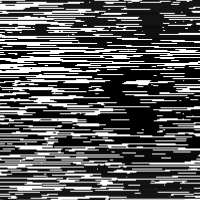

In [8]:
img_f = fnames[100]
img = Image.open(img_f)
img

In [9]:
def get_y_fn(fn): return path/"labels"/f"{fn.stem}_P{fn.suffix}"

print(get_y_fn(img_f))

/content/gdrive/My Drive/fastai-v3/data/segmentation/one-strong/labels/one-strong_s-0.075_pos-18630852_seed-591_ancestry_P.png


In [ ]:
??IntToFloatTensor

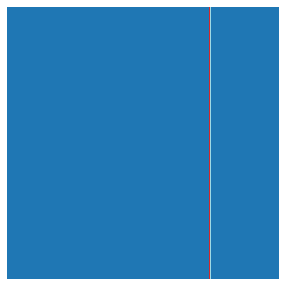

In [10]:
mask = OpenMask(get_y_fn(img_f))
mask.show(alpha=1)

In [11]:
torch.set_printoptions(profile="full")
print(mask.getcolors())

[(39800, 0), (200, 255)]


In [12]:
codes = np.array(['neutral', 'sweep'], dtype=str)

In [13]:
def MaskBlock(codes=None):
    "A `TransformBlock` for segmentation masks, potentially with `codes`"
    return TransformBlock(type_tfms=PILMask.create, item_tfms=AddMaskCodes(codes=codes), 
                          batch_tfms=IntToFloatTensor(div_mask=255))

In [14]:
dbs = DataBlock(blocks=(ImageBlock, MaskBlock(codes,)),
                   get_items = get_image_files,
                   get_y = get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.2, seed=42))

In [15]:
dls = dbs.dataloaders(path_img, path=path, bs=8)

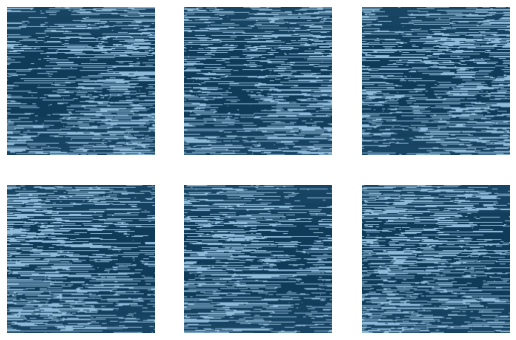

In [16]:
dls.show_batch(max_n=6)

In [506]:
from sklearn.metrics import auc

def mean_auc(pred, targ, axis = 1):
  targ = targ.squeeze(1)
  pred = pred.argmax(dim=axis)
  targs = torch.where(torch.sigmoid(targ.sum(dim=1).float())>0.5, torch.sigmoid(targ.sum(dim=1).float()), tensor(0.).cuda())
  preds = torch.where(torch.sigmoid(pred.sum(dim=1).float())>0.5, torch.sigmoid(pred.sum(dim=1).float()), tensor(0.).cuda())

  
  positions = torch.arange(0, 200).cuda()
  positions = positions.view(1, 200, 1).cuda()
  distances = torch.transpose(torch.sub(torch.where(targs==1.)[1], positions).abs().squeeze(), 0, 1)

  window_means = torch.Tensor([[preds[y][torch.where(distances[y]<= i)].mean() for i in range(100)] for y in range(len(preds))]).mean(0)
  
  batch_auc = auc(torch.arange(0, 100), window_means)

  return batch_auc

In [507]:
def mean_pos0(pred, targ, axis = 1):
  targ = targ.squeeze(1)
  pred = pred.argmax(dim=axis)
  targs = torch.where(torch.sigmoid(targ.sum(dim=1).float())>0.5, torch.sigmoid(targ.sum(dim=1).float()), tensor(0.).cuda())
  preds = torch.where(torch.sigmoid(pred.sum(dim=1).float())>0.5, torch.sigmoid(pred.sum(dim=1).float()), tensor(0.).cuda())

  
  positions = torch.arange(0, 200).cuda()
  positions = positions.view(1, 200, 1).cuda()
  distances = torch.transpose(torch.sub(torch.where(targs==1.)[1], positions).abs().squeeze(), 0, 1)

  window_means = torch.Tensor([[preds[y][torch.where(distances[y]<= i)].mean() for i in range(100)] for y in range(len(preds))]).mean(0)

  return window_means[0]

def mean_pos10(pred, targ, axis = 1):
  targ = targ.squeeze(1)
  pred = pred.argmax(dim=axis)
  targs = torch.where(torch.sigmoid(targ.sum(dim=1).float())>0.5, torch.sigmoid(targ.sum(dim=1).float()), tensor(0.).cuda())
  preds = torch.where(torch.sigmoid(pred.sum(dim=1).float())>0.5, torch.sigmoid(pred.sum(dim=1).float()), tensor(0.).cuda())

  
  positions = torch.arange(0, 200).cuda()
  positions = positions.view(1, 200, 1).cuda()
  distances = torch.transpose(torch.sub(torch.where(targs==1.)[1], positions).abs().squeeze(), 0, 1)

  window_means = torch.Tensor([[preds[y][torch.where(distances[y]<= i)].mean() for i in range(100)] for y in range(len(preds))]).mean(0)

  return window_means[10]

In [508]:
learn = unet_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(axis=1, 
                    weight=torch.tensor([0.5,1.]).cuda()), metrics=[mean_auc, mean_pos0, mean_pos10])

In [509]:
learn.fine_tune(20, base_lr=3e-5, freeze_epochs=10,pct_start=0.9, wd=1e-2)

epoch,train_loss,valid_loss,mean_auc,mean_pos0,mean_pos10,time
0,0.237318,0.105883,61.337972,0.664503,0.672783,00:31
1,0.100722,0.074085,2.976785,0.042454,0.040287,00:30
2,0.063813,0.053296,0.117352,0.000000,0.000661,00:30
3,0.048708,0.044777,0.014536,0.000000,0.000244,00:31
4,0.042549,0.041231,0.000000,0.000000,0.000000,00:30
5,0.039144,0.038540,0.000000,0.000000,0.000000,00:30
6,0.036809,0.036981,0.000000,0.000000,0.000000,00:30
7,0.034493,0.037191,0.000000,0.000000,0.000000,00:30
8,0.032882,0.036544,0.008291,0.000000,0.000210,00:31
9,0.030847,0.039752,0.165022,0.004404,0.004045,00:30


epoch,train_loss,valid_loss,mean_auc,mean_pos0,mean_pos10,time
0,0.027437,0.040278,0.538348,0.038556,0.012009,00:31
1,0.026767,0.042606,1.519432,0.092890,0.034882,00:32
2,0.026203,0.044346,1.828391,0.136490,0.041641,00:32
3,0.025650,0.045585,2.281094,0.138724,0.052326,00:32
4,0.024987,0.049392,2.775052,0.163496,0.064334,00:32
5,0.024312,0.049620,3.036840,0.204969,0.068271,00:32
6,0.023918,0.049437,4.596864,0.273232,0.107117,00:32
7,0.023382,0.059151,6.574491,0.368264,0.151964,00:32
8,0.022536,0.057330,6.312740,0.386691,0.144935,00:32
9,0.021835,0.059096,7.053799,0.404476,0.165440,00:32


In [510]:
interp = Interpretation.from_learner(learn)

In [511]:
def mean_auc_cpu(pred, targ):
  targs = torch.where(torch.sigmoid(targ.sum(dim=1).float())>0.5, torch.sigmoid(targ.sum(dim=1).float()), tensor(0.))
  preds = torch.where(torch.sigmoid(pred.sum(dim=1).float())>0.5, torch.sigmoid(pred.sum(dim=1).float()), tensor(0.))

  positions = torch.arange(0, 200)
  positions = positions.view(1, 200, 1)
  distances = torch.transpose(torch.sub(torch.where(targs==1.)[1], positions).abs().squeeze(), 0, 1)

  window_means = torch.Tensor([[preds[y][torch.where(distances[y]<= i)].mean() for i in range(100)] for y in range(len(preds))]).mean(0)
  
  return window_means

In [512]:
window_means = mean_auc_cpu(interp.decoded, interp.targs)

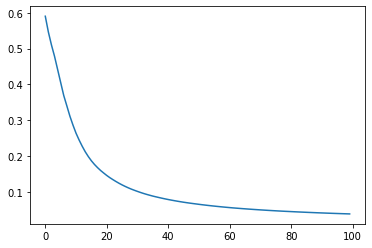

In [513]:
matplotlib.pyplot.plot(window_means)

In [514]:
window_means[0], window_means[10]

(tensor(0.5900), tensor(0.2639))

In [515]:
learn.fit_one_cycle(8, lr_max=3e-5)

epoch,train_loss,valid_loss,mean_auc,mean_pos0,mean_pos10,time
0,0.015703,0.098464,12.002695,0.588708,0.282413,00:32
1,0.019265,0.057628,7.430831,0.358139,0.174179,00:32
2,0.021387,0.047320,9.780897,0.460721,0.223765,00:32
3,0.019084,0.053832,8.287128,0.390973,0.189367,00:32
4,0.016956,0.063926,9.457602,0.400397,0.221266,00:32
5,0.013593,0.071038,11.169602,0.524496,0.259566,00:32
6,0.010325,0.088293,9.626084,0.474787,0.222134,00:32
7,0.008742,0.096731,9.059047,0.447370,0.210155,00:31


In [516]:
interp = Interpretation.from_learner(learn)

In [517]:
window_means = mean_auc_cpu(interp.decoded, interp.targs)

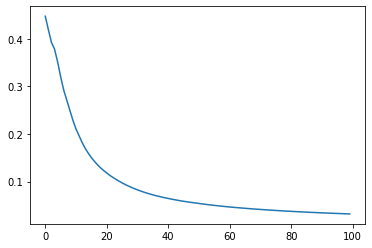

In [518]:
matplotlib.pyplot.plot(window_means)

In [519]:
window_means[0], window_means[10]

(tensor(0.4474), tensor(0.2102))

In [520]:
learn.fit_one_cycle(10, wd=1e-2, lr = slice(3e-5))

epoch,train_loss,valid_loss,mean_auc,mean_pos0,mean_pos10,time
0,0.028317,0.034430,0.120787,0.014133,0.002696,00:32
1,0.031335,0.032921,0.242280,0.025848,0.005181,00:32
2,0.030337,0.034501,0.008453,0.000000,0.000174,00:32
3,0.028562,0.032041,0.000000,0.000000,0.000000,00:31
4,0.026540,0.033534,0.000000,0.000000,0.000000,00:32
5,0.025166,0.032677,0.000000,0.000000,0.000000,00:31
6,0.023304,0.032496,0.155014,0.022680,0.003100,00:32
7,0.019407,0.037665,7.101505,0.545173,0.155452,00:32
8,0.015862,0.050868,10.257111,0.673942,0.229500,00:32
9,0.012521,0.064211,10.107177,0.658454,0.227076,00:32


In [521]:
interp = Interpretation.from_learner(learn)

In [522]:
window_means = mean_auc_cpu(interp.decoded, interp.targs)

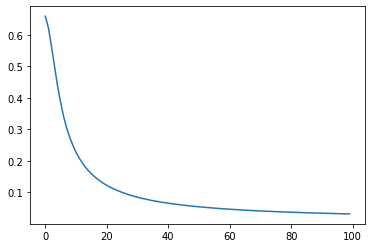

In [523]:
matplotlib.pyplot.plot(window_means)

In [524]:
window_means[0], window_means[10]

(tensor(0.6585), tensor(0.2271))

In [525]:
learn.fine_tune(5, freeze_epochs=5)

epoch,train_loss,valid_loss,mean_auc,mean_pos0,mean_pos10,time
0,0.011890,0.065222,11.405474,0.704867,0.258543,00:31
1,0.014007,0.056037,9.540545,0.635364,0.213246,00:31
2,0.014996,0.074628,12.099638,0.723331,0.275054,00:31
3,0.016846,0.037294,12.221889,0.688803,0.275719,00:31
4,0.018703,0.043896,0.000000,0.000000,0.000000,00:31


epoch,train_loss,valid_loss,mean_auc,mean_pos0,mean_pos10,time
0,0.012833,0.095442,11.424605,0.664547,0.259660,00:32
1,0.013378,0.077037,11.992939,0.686969,0.273763,00:32
2,0.012578,0.093258,11.288776,0.681672,0.255244,00:32
3,0.009527,0.101172,11.580418,0.684108,0.261110,00:32
4,0.006125,0.137898,11.081012,0.664002,0.250049,00:32


In [526]:
interp = Interpretation.from_learner(learn)

In [527]:
window_means = mean_auc_cpu(interp.decoded, interp.targs)

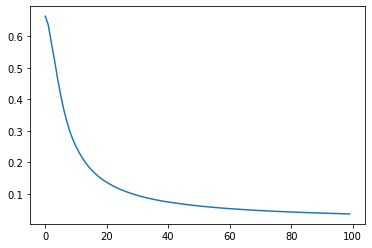

In [528]:
matplotlib.pyplot.plot(window_means)

In [529]:
window_means[0], window_means[10]

(tensor(0.6640), tensor(0.2500))

In [530]:
pred_sums = []

for i in interp.decoded:
  pred_colsum = i.sum(dim=0)
  pred_sums.append(pred_colsum)

In [531]:
target = interp.targs

In [532]:
targ_sums = []

for i in target:
  targ_colsum = i.sum(dim=0)
  targ_sums.append(targ_colsum)

In [533]:
import numpy as np
import pandas as pd

pred_sums_np = np.asarray([to_np(i) for i in pred_sums])
pred_sums_df = pd.DataFrame(pred_sums_np)

targ_sums_np = np.asarray([to_np(i) for i in targ_sums])
targ_sums_df = pd.DataFrame(targ_sums_np)

In [534]:
pred_sums_df.to_csv("/content/gdrive/My Drive/fastai-v3/data/pred_sums_one-strong2.txt", sep="\t")
targ_sums_df.to_csv("/content/gdrive/My Drive/fastai-v3/data/target_sums_one-strong2.txt", sep="\t")